# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
!pip install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (7.0.0)


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.ToPILImage(),
                                       #transforms.Lambda(lambda x: x.convert('RGB')),
                                       transforms.ToTensor(),
                                       #transforms.RandomRotation(30),
                                       #
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.ToPILImage(),
                                       #transforms.Lambda(lambda x: x.convert('RGB')),
                                       transforms.ToTensor(),
                                       #transforms.RandomRotation(30),
                                       
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


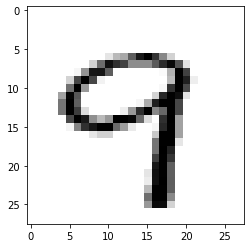

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already

# dataiter = iter(train_loader)

#'''

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
#'''

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

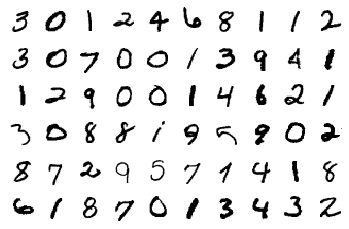

In [6]:
#'''
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
#'''

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.1),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=0.1),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             288
              ReLU-5            [-1, 8, 24, 24]               0
            Conv2d-6           [-1, 16, 22, 22]           1,152
       BatchNorm2d-7           [-1, 16, 22, 22]              32
         Dropout2d-8           [-1, 16, 22, 22]               0
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             256
             ReLU-12           [-1, 16, 11, 11]               0
           Conv2d-13             [-1, 32, 9, 9]           4,608
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    scheduler.step()
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10476934909820557 Batch_id=468 Accuracy=92.97: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9818/10000 (98.18%)

EPOCH: 1


Loss=0.04194670915603638 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.1273728609085083 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:11<00:00, 40.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.07664941996335983 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.060840025544166565 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.03928734362125397 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.030398109927773476 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.02491079829633236 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.041729241609573364 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.014559035189449787 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 40.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.016962150111794472 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.03571208938956261 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.03674900531768799 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:11<00:00, 40.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.009397963993251324 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.0250131543725729 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 40.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.030418818816542625 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9916/10000 (99.16%)

EPOCH: 16


Loss=0.02033432386815548 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 40.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.02112755738198757 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:11<00:00, 39.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.04993414506316185 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9918/10000 (99.18%)

EPOCH: 19


Loss=0.0046838722191751 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 40.45it/s]



Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)



Text(0.5, 1.0, 'Test Accuracy')

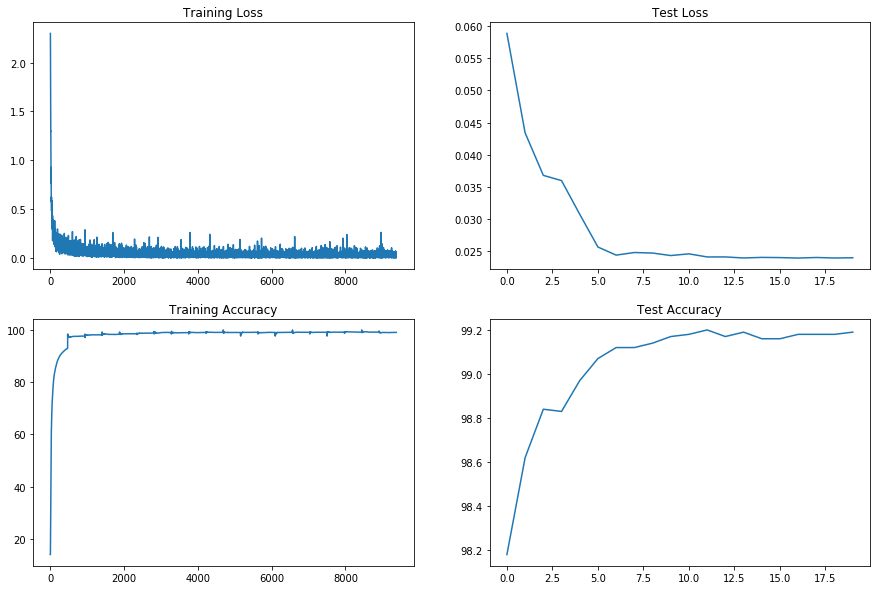

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
import PIL
print('PIL',PIL.__version__)

PIL 7.0.0


# Observations/Updates


*   Updated the Network to reduce the paramters and brought it to under 13K
*   Removed one conv block
*   Added Batch Normalization, Dropout after the conv block
*   Achieved accuracy of 99.2%
*   Facing Error while rotating. Seems like a existing bug while handling grayscale images


